In [1]:
# Copyright (c) Meta Platforms, Inc. and affiliates.
# Once the repo is cloned then:
#best practice remove and reeinstal fspec


# instal using the setup.py inside the sam2 repo
#pip install e .
#pip install -e ".[demo]"


#install also to vizualize figures
# !sudo apt-get update
# !sudo apt-get install -y libgl1-mesa-glx
# !sudo apt-get install -y libglib2.0-0

# #Necessary dependencies
# !rm -rf /opt/conda/lib/python3.10/site-packages/fsspec*
# !pip install fsspec==2024.6.1 --force-reinstall --no-deps
# !pip install shapely
# !pip install s3fs
# !pip install rasterio

## Running an example of general segmentation using SAM2

In this example, the model segments everything it finds in the image.


In [2]:
import os
# if using Apple MPS, fall back to CPU for unsupported ops
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image

In [3]:
# select the device for computation
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"using device: {device}")

if device.type == "cuda":
    # use bfloat16 for the entire notebook
    torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
elif device.type == "mps":
    print(
        "\nSupport for MPS devices is preliminary. SAM 2 is trained with CUDA and might "
        "give numerically different outputs and sometimes degraded performance on MPS. "
        "See e.g. https://github.com/pytorch/pytorch/issues/84936 for a discussion."
    )

using device: cuda


In [4]:
np.random.seed(3)

def show_anns(anns, borders=True):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:, :, 3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.5]])
        img[m] = color_mask 
        if borders:
            import cv2
            contours, _ = cv2.findContours(m.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) 
            # Try to smooth contours
            contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
            cv2.drawContours(img, contours, -1, (0, 0, 1, 0.4), thickness=1) 

    ax.imshow(img)

### Geting the image from Solafune competition uploaded to my s3 bucket

In [5]:
import rasterio
import numpy as np

def load_image_as_array(image_s3_uri):
    """Load an image from S3 and convert it to a NumPy array."""
    # Open the image using rasterio
    with rasterio.open(image_s3_uri) as src:
        # Read the image data
        image = src.read()  # This will read all the bands
        image = np.moveaxis(image, 0, -1)  # Move channels to the last dimension
        image = image[:, :, :3]  # Assuming you want to use only the first 3 bands (R, G, B)
    return image

# Example usage
image_s3_uri = 's3://solafune/train_images/images/train_25.tif'
image = load_image_as_array(image_s3_uri)

# Now 'image' is a NumPy array in RGB format
print(image.shape)  # This will print the shape of the image array


# Assuming 'image' is the array you loaded
image_normalized = (image - np.min(image)) / (np.max(image) - np.min(image)) * 255
image_normalized = image_normalized.astype(np.uint8)  # Convert to uint8

image = image_normalized

(802, 1198, 3)


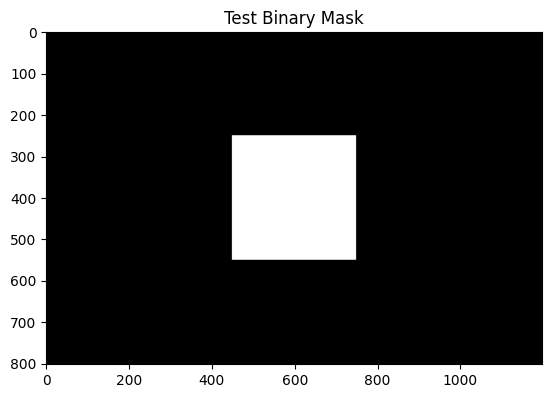

In [8]:
import numpy as np

def create_test_binary_mask(image_shape: Tuple[int, int, int], mask_size: int = 300) -> np.ndarray:
    height, width, _ = image_shape

    # Initialize the binary mask with zeros
    binary_mask = np.zeros((height, width), dtype=np.uint8)

    # Calculate the top-left corner of the square mask
    start_y = (height - mask_size) // 2
    start_x = (width - mask_size) // 2

    # Ensure the mask doesn't exceed the image boundaries
    end_y = min(start_y + mask_size, height)
    end_x = min(start_x + mask_size, width)

    # Place the square mask at the center
    binary_mask[start_y:end_y, start_x:end_x] = 1

    return binary_mask

# Example usage
image_shape = image.shape
binary_mask = create_test_binary_mask(image_shape)

# If you want to visualize the binary mask
import matplotlib.pyplot as plt
plt.imshow(binary_mask, cmap='gray')
plt.title('Test Binary Mask')
plt.show()


# Creating a Custom Class CustomSAM2AutomaticMaskGenerator

In [6]:
# Customized from Meta
# Copyright (c) Meta Platforms, Inc. and affiliates.
# All rights reserved.

# This source code is licensed under the license found in the
# LICENSE file in the root directory of this source tree.

# Adapted from https://github.com/facebookresearch/segment-anything/blob/main/segment_anything/automatic_mask_generator.py
from typing import Any, Dict, List, Optional, Tuple

import numpy as np
import torch
from torchvision.ops.boxes import batched_nms, box_area  # type: ignore

from sam2.modeling.sam2_base import SAM2Base
from sam2.sam2_image_predictor import SAM2ImagePredictor
from sam2.utils.amg import (
    area_from_rle,
    batch_iterator,
    batched_mask_to_box,
    box_xyxy_to_xywh,
    build_all_layer_point_grids,
    calculate_stability_score,
    coco_encode_rle,
    generate_crop_boxes,
    is_box_near_crop_edge,
    mask_to_rle_pytorch,
    MaskData,
    remove_small_regions,
    rle_to_mask,
    uncrop_boxes_xyxy,
    uncrop_masks,
    uncrop_points,
)


class CustomSAM2AutomaticMaskGenerator:
    def __init__(
        self,
        model: SAM2Base,
        points_per_side: Optional[int] = 32,
        points_per_batch: int = 64,
        pred_iou_thresh: float = 0.8,
        stability_score_thresh: float = 0.95,
        stability_score_offset: float = 1.0,
        mask_threshold: float = 0.0,
        box_nms_thresh: float = 0.7,
        crop_n_layers: int = 0,
        crop_nms_thresh: float = 0.7,
        crop_overlap_ratio: float = 512 / 1500,
        crop_n_points_downscale_factor: int = 1,
        point_grids: Optional[List[np.ndarray]] = None,
        min_mask_region_area: int = 0,
        output_mode: str = "binary_mask",
        use_m2m: bool = False,
        multimask_output: bool = True,
        **kwargs,
    ) -> None:
        """
        Using a SAM 2 model, generates masks for the entire image.
        Generates a grid of point prompts over the image, then filters
        low quality and duplicate masks. The default settings are chosen
        for SAM 2 with a HieraL backbone.

        Arguments:
          model (Sam): The SAM 2 model to use for mask prediction.
          points_per_side (int or None): The number of points to be sampled
            along one side of the image. The total number of points is
            points_per_side**2. If None, 'point_grids' must provide explicit
            point sampling.
          points_per_batch (int): Sets the number of points run simultaneously
            by the model. Higher numbers may be faster but use more GPU memory.
          pred_iou_thresh (float): A filtering threshold in [0,1], using the
            model's predicted mask quality.
          stability_score_thresh (float): A filtering threshold in [0,1], using
            the stability of the mask under changes to the cutoff used to binarize
            the model's mask predictions.
          stability_score_offset (float): The amount to shift the cutoff when
            calculated the stability score.
          mask_threshold (float): Threshold for binarizing the mask logits
          box_nms_thresh (float): The box IoU cutoff used by non-maximal
            suppression to filter duplicate masks.
          crop_n_layers (int): If >0, mask prediction will be run again on
            crops of the image. Sets the number of layers to run, where each
            layer has 2**i_layer number of image crops.
          crop_nms_thresh (float): The box IoU cutoff used by non-maximal
            suppression to filter duplicate masks between different crops.
          crop_overlap_ratio (float): Sets the degree to which crops overlap.
            In the first crop layer, crops will overlap by this fraction of
            the image length. Later layers with more crops scale down this overlap.
          crop_n_points_downscale_factor (int): The number of points-per-side
            sampled in layer n is scaled down by crop_n_points_downscale_factor**n.
          point_grids (list(np.ndarray) or None): A list over explicit grids
            of points used for sampling, normalized to [0,1]. The nth grid in the
            list is used in the nth crop layer. Exclusive with points_per_side.
          min_mask_region_area (int): If >0, postprocessing will be applied
            to remove disconnected regions and holes in masks with area smaller
            than min_mask_region_area. Requires opencv.
          output_mode (str): The form masks are returned in. Can be 'binary_mask',
            'uncompressed_rle', or 'coco_rle'. 'coco_rle' requires pycocotools.
            For large resolutions, 'binary_mask' may consume large amounts of
            memory.
          use_m2m (bool): Whether to add a one step refinement using previous mask predictions.
          multimask_output (bool): Whether to output multimask at each point of the grid.
        """

        assert (points_per_side is None) != (
            point_grids is None
        ), "Exactly one of points_per_side or point_grid must be provided."
        if points_per_side is not None:
            self.point_grids = build_all_layer_point_grids(
                points_per_side,
                crop_n_layers,
                crop_n_points_downscale_factor,
            )
        elif point_grids is not None:
            self.point_grids = point_grids
        else:
            raise ValueError("Can't have both points_per_side and point_grid be None.")

        assert output_mode in [
            "binary_mask",
            "uncompressed_rle",
            "coco_rle",
        ], f"Unknown output_mode {output_mode}."
        if output_mode == "coco_rle":
            try:
                from pycocotools import mask as mask_utils  # type: ignore  # noqa: F401
            except ImportError as e:
                print("Please install pycocotools")
                raise e

        self.predictor = SAM2ImagePredictor(
            model,
            max_hole_area=min_mask_region_area,
            max_sprinkle_area=min_mask_region_area,
        )
        self.points_per_batch = points_per_batch
        self.pred_iou_thresh = pred_iou_thresh
        self.stability_score_thresh = stability_score_thresh
        self.stability_score_offset = stability_score_offset
        self.mask_threshold = mask_threshold
        self.box_nms_thresh = box_nms_thresh
        self.crop_n_layers = crop_n_layers
        self.crop_nms_thresh = crop_nms_thresh
        self.crop_overlap_ratio = crop_overlap_ratio
        self.crop_n_points_downscale_factor = crop_n_points_downscale_factor
        self.min_mask_region_area = min_mask_region_area
        self.output_mode = output_mode
        self.use_m2m = use_m2m
        self.multimask_output = multimask_output

    @classmethod
    def from_pretrained(cls, model_id: str, **kwargs) -> "SAM2AutomaticMaskGenerator":
        """
        Load a pretrained model from the Hugging Face hub.

        Arguments:
          model_id (str): The Hugging Face repository ID.
          **kwargs: Additional arguments to pass to the model constructor.

        Returns:
          (SAM2AutomaticMaskGenerator): The loaded model.
        """
        from sam2.build_sam import build_sam2_hf

        sam_model = build_sam2_hf(model_id, **kwargs)
        return cls(sam_model, **kwargs)

    @torch.no_grad()
    def generate(self, image: np.ndarray, binary_mask: np.ndarray) -> List[Dict[str, Any]]:
        """
        Generates masks for the given image.
    
        Arguments:
          image (np.ndarray): The image to generate masks for, in HWC uint8 format.
          binary_mask (np.ndarray): A binary mask where non-zero values indicate
            points of interest for segmentation.
    
        Returns:
           list(dict(str, any)): A list over records for masks.
        """
        # Ensure the binary mask has the same dimensions as the image
        assert binary_mask.shape[:2] == image.shape[:2], "Binary mask must match image dimensions."
    
        # Generate masks using the binary mask
        mask_data = self._generate_masks(image, binary_mask)
    
        # Encode masks
        if self.output_mode == "coco_rle":
            mask_data["segmentations"] = [
                coco_encode_rle(rle) for rle in mask_data["rles"]
            ]
        elif self.output_mode == "binary_mask":
            mask_data["segmentations"] = [rle_to_mask(rle) for rle in mask_data["rles"]]
        else:
            mask_data["segmentations"] = mask_data["rles"]
    
        # Write mask records
        curr_anns = []
        for idx in range(len(mask_data["segmentations"])):
            ann = {
                "segmentation": mask_data["segmentations"][idx],
                "area": area_from_rle(mask_data["rles"][idx]),
                "bbox": box_xyxy_to_xywh(mask_data["boxes"][idx]).tolist(),
                "predicted_iou": mask_data["iou_preds"][idx].item(),
                "point_coords": [mask_data["points"][idx].tolist()],
                "stability_score": mask_data["stability_score"][idx].item(),
                "crop_box": box_xyxy_to_xywh(mask_data["crop_boxes"][idx]).tolist(),
            }
            curr_anns.append(ann)
    
        return curr_anns


    def _generate_masks(self, image: np.ndarray, binary_mask: np.ndarray) -> MaskData:
        orig_size = image.shape[:2]
        crop_boxes, layer_idxs = generate_crop_boxes(
            orig_size, self.crop_n_layers, self.crop_overlap_ratio
        )
    
        # Iterate over image crops
        data = MaskData()
        for crop_box, layer_idx in zip(crop_boxes, layer_idxs):
            crop_data = self._process_crop(image, binary_mask, crop_box, layer_idx, orig_size)
            data.cat(crop_data)
    
        # Remove duplicate masks between crops
        if len(crop_boxes) > 1:
            # Prefer masks from smaller crops
            scores = 1 / box_area(data["crop_boxes"])
            scores = scores.to(data["boxes"].device)
            keep_by_nms = batched_nms(
                data["boxes"].float(),
                scores,
                torch.zeros_like(data["boxes"][:, 0]),  # categories
                iou_threshold=self.crop_nms_thresh,
            )
            data.filter(keep_by_nms)
        data.to_numpy()
        return data


    def _process_crop(
        self,
        image: np.ndarray,
        binary_mask: np.ndarray,
        crop_box: List[int],
        crop_layer_idx: int,
        orig_size: Tuple[int, ...],
    ) -> MaskData:
        # Crop the image and the binary mask
        x0, y0, x1, y1 = crop_box
        cropped_im = image[y0:y1, x0:x1, :]
        cropped_mask = binary_mask[y0:y1, x0:x1]
        cropped_im_size = cropped_im.shape[:2]
        self.predictor.set_image(cropped_im)
    
        # Get points for this crop, filter by binary mask
        points_scale = np.array(cropped_im_size)[None, ::-1]
        points_for_image = self.point_grids[crop_layer_idx] * points_scale
        valid_points = points_for_image[cropped_mask[points_for_image[:, 1].astype(int), points_for_image[:, 0].astype(int)] > 0]
    
        # Generate masks for this crop in batches
        data = MaskData()
        for (points,) in batch_iterator(self.points_per_batch, valid_points):
            batch_data = self._process_batch(
                points, cropped_im_size, crop_box, orig_size, normalize=True
            )
            data.cat(batch_data)
            del batch_data
        self.predictor.reset_predictor()
    
        # Remove duplicates within this crop.
        keep_by_nms = batched_nms(
            data["boxes"].float(),
            data["iou_preds"],
            torch.zeros_like(data["boxes"][:, 0]),  # categories
            iou_threshold=self.box_nms_thresh,
        )
        data.filter(keep_by_nms)
    
        # Return to the original image frame
        data["boxes"] = uncrop_boxes_xyxy(data["boxes"], crop_box)
        data["points"] = uncrop_points(data["points"], crop_box)
        data["crop_boxes"] = torch.tensor([crop_box for _ in range(len(data["rles"]))])
    
        return data


    def _process_batch(
        self,
        points: np.ndarray,
        im_size: Tuple[int, ...],
        crop_box: List[int],
        orig_size: Tuple[int, ...],
        normalize=False,
    ) -> MaskData:
        orig_h, orig_w = orig_size

        # Run model on this batch
        points = torch.as_tensor(
            points, dtype=torch.float32, device=self.predictor.device
        )
        in_points = self.predictor._transforms.transform_coords(
            points, normalize=normalize, orig_hw=im_size
        )
        in_labels = torch.ones(
            in_points.shape[0], dtype=torch.int, device=in_points.device
        )
        masks, iou_preds, low_res_masks = self.predictor._predict(
            in_points[:, None, :],
            in_labels[:, None],
            multimask_output=self.multimask_output,
            return_logits=True,
        )

        # Serialize predictions and store in MaskData
        data = MaskData(
            masks=masks.flatten(0, 1),
            iou_preds=iou_preds.flatten(0, 1),
            points=points.repeat_interleave(masks.shape[1], dim=0),
            low_res_masks=low_res_masks.flatten(0, 1),
        )
        del masks

        if not self.use_m2m:
            # Filter by predicted IoU
            if self.pred_iou_thresh > 0.0:
                keep_mask = data["iou_preds"] > self.pred_iou_thresh
                data.filter(keep_mask)

            # Calculate and filter by stability score
            data["stability_score"] = calculate_stability_score(
                data["masks"], self.mask_threshold, self.stability_score_offset
            )
            if self.stability_score_thresh > 0.0:
                keep_mask = data["stability_score"] >= self.stability_score_thresh
                data.filter(keep_mask)
        else:
            # One step refinement using previous mask predictions
            in_points = self.predictor._transforms.transform_coords(
                data["points"], normalize=normalize, orig_hw=im_size
            )
            labels = torch.ones(
                in_points.shape[0], dtype=torch.int, device=in_points.device
            )
            masks, ious = self.refine_with_m2m(
                in_points, labels, data["low_res_masks"], self.points_per_batch
            )
            data["masks"] = masks.squeeze(1)
            data["iou_preds"] = ious.squeeze(1)

            if self.pred_iou_thresh > 0.0:
                keep_mask = data["iou_preds"] > self.pred_iou_thresh
                data.filter(keep_mask)

            data["stability_score"] = calculate_stability_score(
                data["masks"], self.mask_threshold, self.stability_score_offset
            )
            if self.stability_score_thresh > 0.0:
                keep_mask = data["stability_score"] >= self.stability_score_thresh
                data.filter(keep_mask)

        # Threshold masks and calculate boxes
        data["masks"] = data["masks"] > self.mask_threshold
        data["boxes"] = batched_mask_to_box(data["masks"])

        # Filter boxes that touch crop boundaries
        keep_mask = ~is_box_near_crop_edge(
            data["boxes"], crop_box, [0, 0, orig_w, orig_h]
        )
        if not torch.all(keep_mask):
            data.filter(keep_mask)

        # Compress to RLE
        data["masks"] = uncrop_masks(data["masks"], crop_box, orig_h, orig_w)
        data["rles"] = mask_to_rle_pytorch(data["masks"])
        del data["masks"]

        return data

    @staticmethod
    def postprocess_small_regions(
        mask_data: MaskData, min_area: int, nms_thresh: float
    ) -> MaskData:
        """
        Removes small disconnected regions and holes in masks, then reruns
        box NMS to remove any new duplicates.

        Edits mask_data in place.

        Requires open-cv as a dependency.
        """
        if len(mask_data["rles"]) == 0:
            return mask_data

        # Filter small disconnected regions and holes
        new_masks = []
        scores = []
        for rle in mask_data["rles"]:
            mask = rle_to_mask(rle)

            mask, changed = remove_small_regions(mask, min_area, mode="holes")
            unchanged = not changed
            mask, changed = remove_small_regions(mask, min_area, mode="islands")
            unchanged = unchanged and not changed

            new_masks.append(torch.as_tensor(mask).unsqueeze(0))
            # Give score=0 to changed masks and score=1 to unchanged masks
            # so NMS will prefer ones that didn't need postprocessing
            scores.append(float(unchanged))

        # Recalculate boxes and remove any new duplicates
        masks = torch.cat(new_masks, dim=0)
        boxes = batched_mask_to_box(masks)
        keep_by_nms = batched_nms(
            boxes.float(),
            torch.as_tensor(scores),
            torch.zeros_like(boxes[:, 0]),  # categories
            iou_threshold=nms_thresh,
        )

        # Only recalculate RLEs for masks that have changed
        for i_mask in keep_by_nms:
            if scores[i_mask] == 0.0:
                mask_torch = masks[i_mask].unsqueeze(0)
                mask_data["rles"][i_mask] = mask_to_rle_pytorch(mask_torch)[0]
                mask_data["boxes"][i_mask] = boxes[i_mask]  # update res directly
        mask_data.filter(keep_by_nms)

        return mask_data

    def refine_with_m2m(self, points, point_labels, low_res_masks, points_per_batch):
        new_masks = []
        new_iou_preds = []

        for cur_points, cur_point_labels, low_res_mask in batch_iterator(
            points_per_batch, points, point_labels, low_res_masks
        ):
            best_masks, best_iou_preds, _ = self.predictor._predict(
                cur_points[:, None, :],
                cur_point_labels[:, None],
                mask_input=low_res_mask[:, None, :],
                multimask_output=False,
                return_logits=True,
            )
            new_masks.append(best_masks)
            new_iou_preds.append(best_iou_preds)
        masks = torch.cat(new_masks, dim=0)
        return masks, torch.cat(new_iou_preds, dim=0)


In [7]:
from sam2.build_sam import build_sam2
#from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator

sam2_checkpoint = "./segment-anything-2/checkpoints/sam2_hiera_large.pt" # try large sam2_hiera_large.pt
model_cfg = "sam2_hiera_l.yaml" #"sam2_hiera_l.yaml" for large

sam2 = build_sam2(model_cfg, sam2_checkpoint, device=device, apply_postprocessing=False)

mask_generator = CustomSAM2AutomaticMaskGenerator(sam2)

In [9]:
masks = mask_generator.generate(image,binary_mask)

In [10]:
print(len(masks))
print(masks[0].keys())

10
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


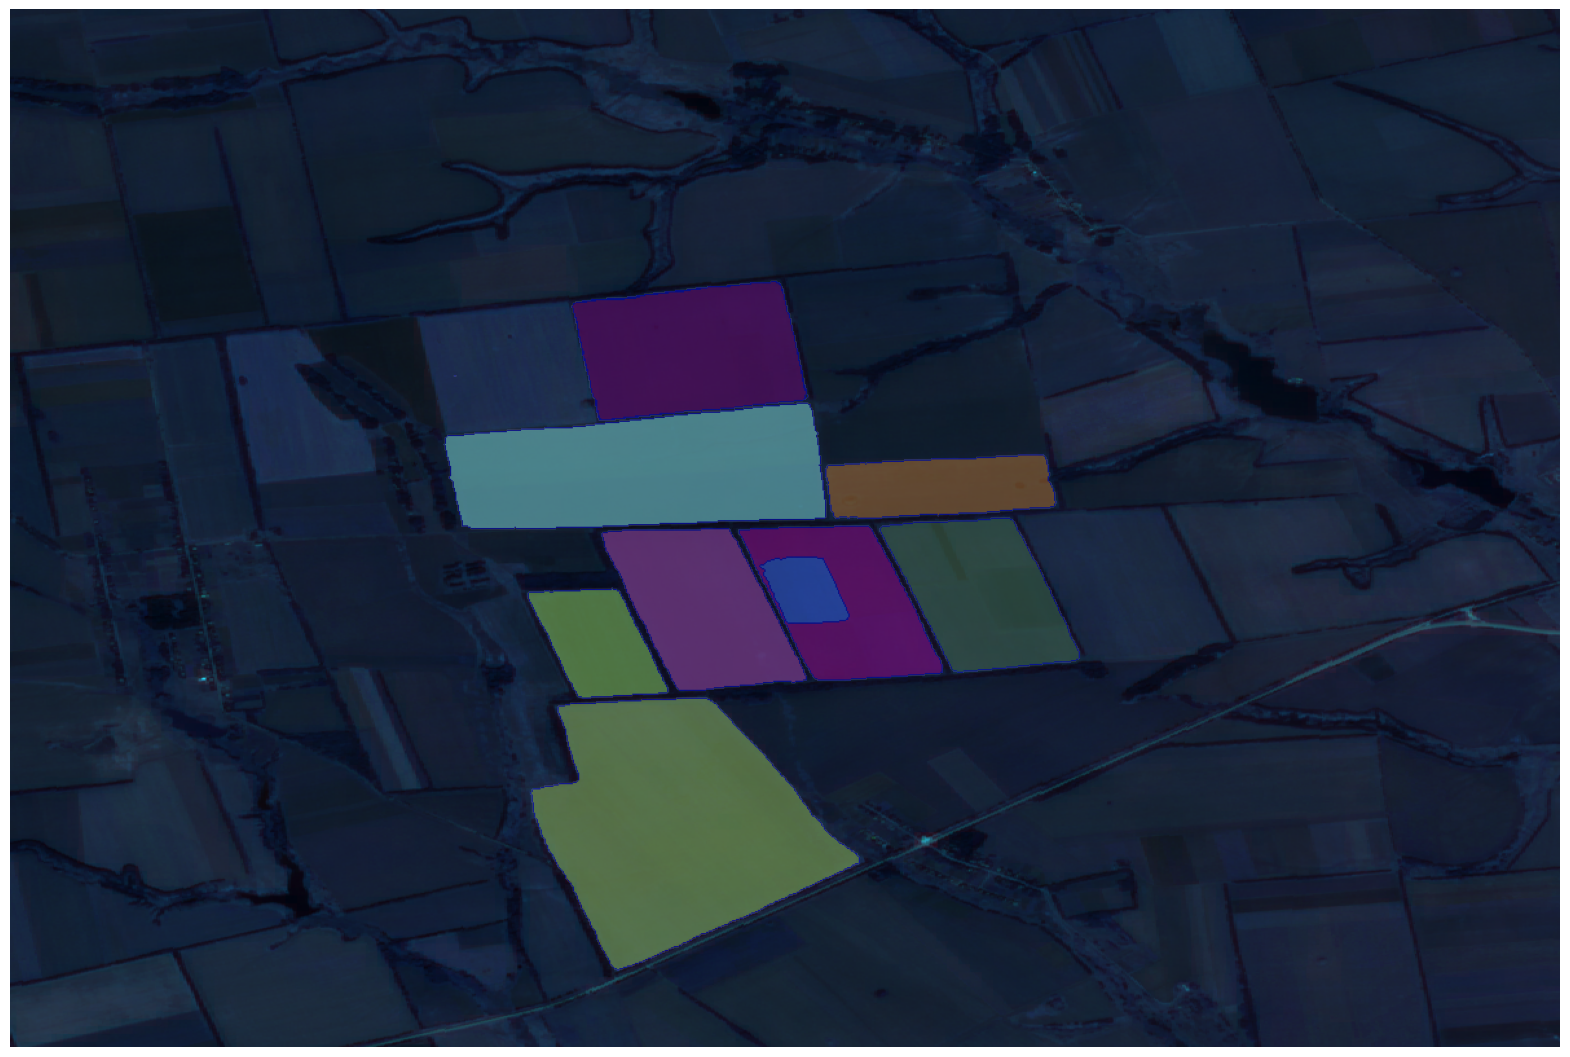

In [11]:
plt.figure(figsize=(20, 20))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show() 

# Finetuning by retraining the model with solafune's data

In [10]:
import numpy as np
import rasterio
from shapely.geometry import Polygon
from shapely.ops import transform
import cv2
from PIL import Image, ImageDraw

def polygon_to_mask(polygon, width, height):
    mask = Image.new('L', (width, height), 0)
    ImageDraw.Draw(mask).polygon(polygon, outline=1, fill=1)
    return torch.tensor(np.array(mask), dtype=torch.float32)


In [11]:
def load_image(image_s3_uri):
    """Load an image from S3 and convert it to a NumPy array."""
    # Open the image using rasterio
    with rasterio.open(image_s3_uri) as src:
        # Read the image data
        image = src.read()  # This will read all the bands
        image = np.moveaxis(image, 0, -1)  # Move channels to the last dimension
        image = image[:, :, :3]  # Assuming you want to use only the first 3 bands (R, G, B)
        image_normalized = (image - np.min(image)) / (np.max(image) - np.min(image)) * 255
        image_normalized = image_normalized.astype(np.uint8)
    return image_normalized


def load_annotations(annotation_s3_uri, image_filename):
    """Load annotations for a specific image from a JSON file on S3."""
    fs = s3fs.S3FileSystem()
    with fs.open(annotation_s3_uri, 'r') as f:
        data = json.load(f)
    
    for img in data['images']:
        if img['file_name'] == image_filename:
            return img['annotations']
    return None
    
def load_original_annotations(annotation_s3_uri):
    """Load annotations for a specific image from a JSON file on S3."""
    fs = s3fs.S3FileSystem()
    with fs.open(annotation_s3_uri, 'r') as f:
        data = json.load(f)
    return data

In [12]:
import torch
from torch.utils.data import Dataset

class SAM2Dataset(Dataset):
    def __init__(self, image_filenames, annotations, image_s3_prefix):
        self.image_filenames = image_filenames
        self.annotations = annotations
        self.image_s3_prefix = image_s3_prefix

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        image_filename = self.image_filenames[idx]
        image_s3_uri = os.path.join(self.image_s3_prefix, image_filename)

        # Load image using the new load_image function
        image = load_image(image_s3_uri)
        
        # Ensure the image is in the correct format for the model
        image_tensor = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1) / 255.0
        
        # Set requires_grad=True to enable gradient computation
        #image_tensor.requires_grad_(True)

        # Load annotations
        annotations = load_annotations(self.annotations, image_filename)
        masks = []
        height, width = image.shape[:2]  # Get the image dimensions
        for annotation in annotations:
            mask = polygon_to_mask(annotation['segmentation'], width, height)
            masks.append(mask)

        # Stack all masks into a single tensor
        masks_tensor = torch.stack(masks, dim=0)

        return image_tensor, masks_tensor


In [13]:
# Load Json
import s3fs
import json
train_annotation_s3_uri = 's3://solafune/train_annotation.json'

In [14]:
from torch.utils.data import DataLoader

# List of image filenames
image_filenames = [img['file_name'] for img in load_original_annotations(train_annotation_s3_uri)['images']]

#image_filenames = ['train_28.tif'] # set a quick training with specific images
image_s3_prefix = 's3://solafune/train_images/images'

# Instantiate Dataset
dataset = SAM2Dataset(image_filenames, train_annotation_s3_uri, image_s3_prefix)

# Create DataLoader
data_loader = DataLoader(dataset, batch_size=1, shuffle=True)

In [18]:
from sam2.build_sam import build_sam2
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator

model = build_sam2(model_cfg, sam2_checkpoint, device=device, apply_postprocessing=False)


In [19]:
def convert_to_binary_masks(predicted_masks):
    """
    Converts boolean masks from SAM2's output to binary masks.

    Args:
    - predicted_masks (list of dict): List of predicted masks with 'segmentation' key containing boolean arrays.

    Returns:
    - binary_masks (list of np.array): List of binary masks (1 and 0).
    """
    binary_masks = []
    for mask_data in predicted_masks:
        # Convert the boolean segmentation mask to an integer binary mask
        binary_mask = mask_data['segmentation'].astype(np.uint8)
        binary_masks.append(binary_mask)
    
    return binary_masks

Batch 1:
 - Image shape before permute: torch.Size([1, 3, 804, 952])
 - Masks shape: torch.Size([1, 302, 804, 952])
 - Image shape after permute: torch.Size([804, 952, 3])


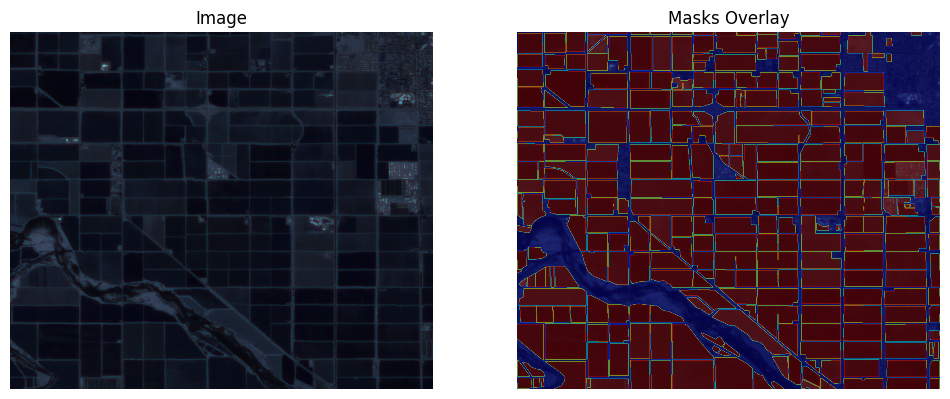

In [20]:
import s3fs
import json

#Looking into the data - Checking if everything is in good order #  image and gt masks


for i, (images, masks) in enumerate(data_loader):
    print(f"Batch {i + 1}:")
    print(f" - Image shape before permute: {images.shape}")
    print(f" - Masks shape: {masks.shape}")
    
    # Assuming images are in the shape [B, C, H, W]
    # Permute to shape [H, W, C] for visualization
    image = images[0].permute(1, 2, 0)
    print(f" - Image shape after permute: {image.shape}")
    
    plt.figure(figsize=(12, 6))
    
    # Show the image
    plt.subplot(1, 2, 1)
    plt.imshow(image.detach().numpy())
    plt.title("Image")
    plt.axis('off')
    
    # Show the masks overlayed on the image
    combined_mask = masks[0].sum(axis=0)
    plt.subplot(1, 2, 2)
    plt.imshow(image.detach().numpy())
    plt.imshow(combined_mask, alpha=0.5, cmap='jet')
    plt.title("Masks Overlay")
    plt.axis('off')
    
    plt.show()
    
    # Break after the first batch to inspect
    if i == 0:
        break
